In [1]:
# visualize the iamge using the dataloader class
from data.dataset import SaltDataset

In [2]:
dataset = SaltDataset(
                csv_file ='../data/train.csv',
                image_dir = '../data/train/images',
                mask_dir = '../data/train/masks',
                depths_csv = '../data/depths.csv',
                use_2_5d = True,
                mode = 'train'
            )

In [3]:
dataset_size = len(dataset)
print("dataset size: ", dataset_size)

dataset size:  4000


In [4]:
import random
import numpy as np

idx = random.randint(0, len(dataset)-1)
sample = dataset[idx]
image, mask = sample
print('image shape: ', image.shape)
print('mask shape: ', mask.shape)

image = np.transpose(image, (1, 2, 0))
print('image shape after transpose: ', image.shape)

mask = np.transpose(mask, (1, 2, 0))
print('mask shape after transpose: ', mask.shape)

image shape:  torch.Size([3, 101, 101])
mask shape:  torch.Size([1, 101, 101])
image shape after transpose:  torch.Size([101, 101, 3])
mask shape after transpose:  torch.Size([101, 101, 1])


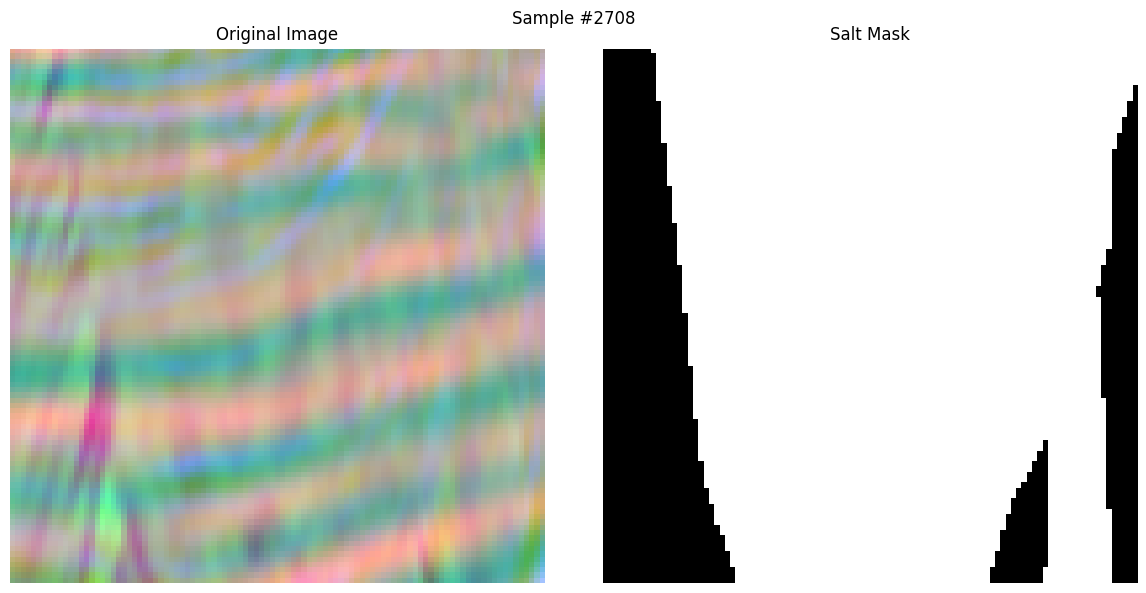

Image shape: torch.Size([101, 101, 3])
Mask shape: torch.Size([101, 101, 1])


In [5]:
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Salt Mask')
plt.axis('off')

plt.suptitle(f'Sample #{idx}')
plt.tight_layout()
plt.show()

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

In [6]:
import torch

# Function to get and preprocess a sample
def get_processed_sample(idx):
    sample = dataset[idx]
    
    # Extract image and mask
    if isinstance(sample, dict):
        image = sample['image']
        mask = sample['mask']
    else:
        # Assuming it's a tuple with (image, mask) format
        image, mask = sample
    
    # Convert to numpy for visualization if they are PyTorch tensors
    if isinstance(image, torch.Tensor):
        image = image.numpy()
        if image.shape[0] == 1 or image.shape[0] == 3:  # CHW format
            image = np.transpose(image, (1, 2, 0))
        if len(image.shape) > 2 and image.shape[-1] == 1:  # Remove singleton dimension
            image = image.squeeze(-1)
            
    if isinstance(mask, torch.Tensor):
        mask = mask.numpy()
        if len(mask.shape) > 2 and mask.shape[0] == 1:  # CHW format with single channel
            mask = mask.squeeze(0)
        if len(mask.shape) > 2 and mask.shape[-1] == 1:  # Remove singleton dimension
            mask = mask.squeeze(-1)
    
    return image, mask


# Function to create overlay visualization
def create_overlay(image, mask, alpha=0.5, mask_color=[1, 0, 0]):
    """
    Create an overlay of the mask on the image.
    
    Args:
        image: Grayscale image
        mask: Binary mask
        alpha: Transparency of the overlay
        mask_color: Color of the mask overlay in RGB
    
    Returns:
        Overlay image
    """
    # Ensure image is in the range [0, 1]
    if image.max() > 1:
        image = image / 255.0
    
    # Create RGB version of grayscale image
    # rgb_image = np.stack([image] * 3, axis=-1)
    print('image shape: ', image.shape)
    # print('rgb image shape: ', rgb_image.shape)
    
    if len(mask.shape) > 2:
        mask = mask.squeeze()

    # Create colored mask
    colored_mask = np.zeros_like(image)
    if len(mask.shape) == 2:  # If mask is 2D
        colored_mask[..., 0] = mask * mask_color[0]
        colored_mask[..., 1] = mask * mask_color[1]
        colored_mask[..., 2] = mask * mask_color[2]
    else:  # If mask is already 3D
        colored_mask = mask
        
    # Create overlay
    overlay = image * (1 - alpha) + colored_mask * alpha
    
    # Clip values to be between 0 and 1
    overlay = np.clip(overlay, 0, 1)
    
    return overlay
    


image shape:  (101, 101, 3)
image shape:  (101, 101, 3)
image shape:  (101, 101, 3)
image shape:  (101, 101, 3)


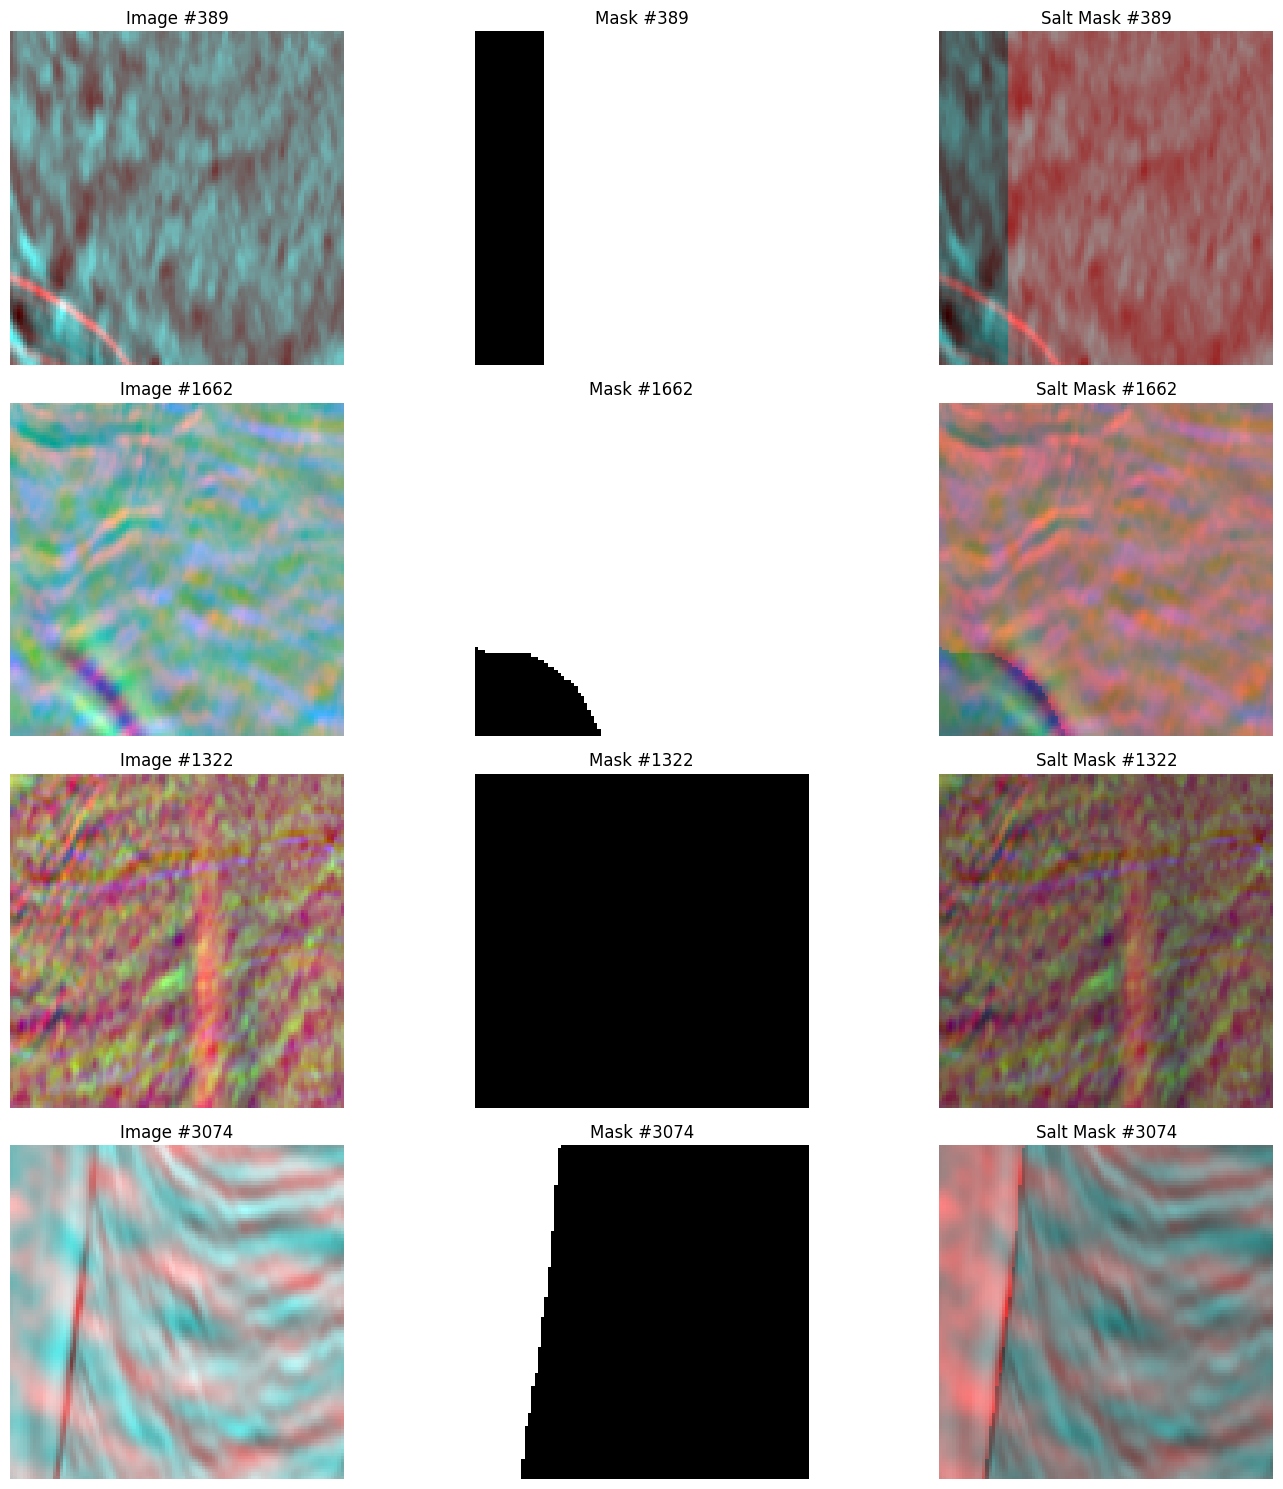

In [7]:
# Display a grid of samples
num_samples = 4
plt.figure(figsize=(15, 15))

for i in range(num_samples):
    idx = random.randint(0, len(dataset)-1)
    image, mask = get_processed_sample(idx)
    
    # Original image
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Image #{idx}')
    plt.axis('off')
    
    # Mask
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Mask #{idx}')
    plt.axis('off')
    
    # Overlay (we'll create this in the next section)
    plt.subplot(num_samples, 3, i*3 + 3)
    overlay = create_overlay(image, mask, alpha=0.3)
    plt.imshow(overlay, cmap='gray')
    plt.title(f'Salt Mask #{idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()

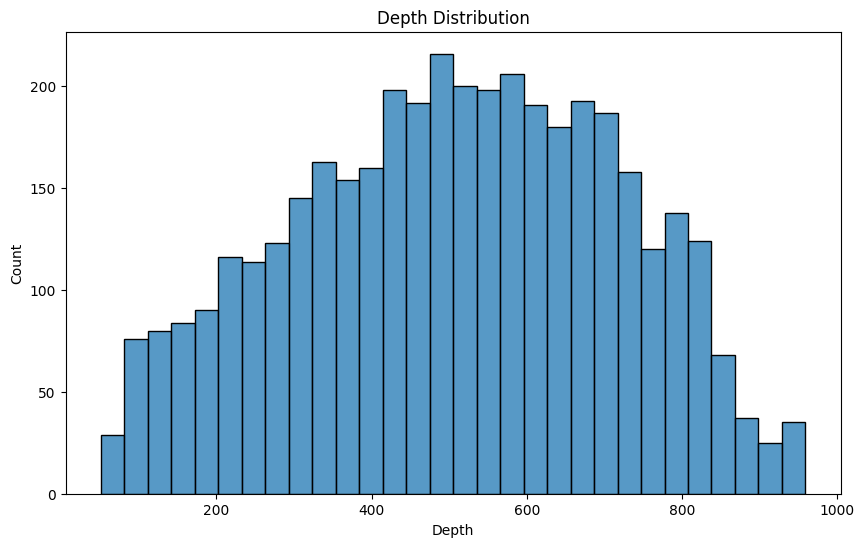

In [8]:
import pandas as pd
import seaborn as sns

# visualize depth distribution
depths = dataset.df

plt.figure(figsize=(10, 6))
if isinstance(depths, pd.DataFrame):
    sns.histplot(depths['z'], bins=30)
else:
    # If depths is a list or array
    sns.histplot(depths, bins=30)
plt.title('Depth Distribution')
plt.xlabel('Depth')
plt.ylabel('Count')
plt.show()

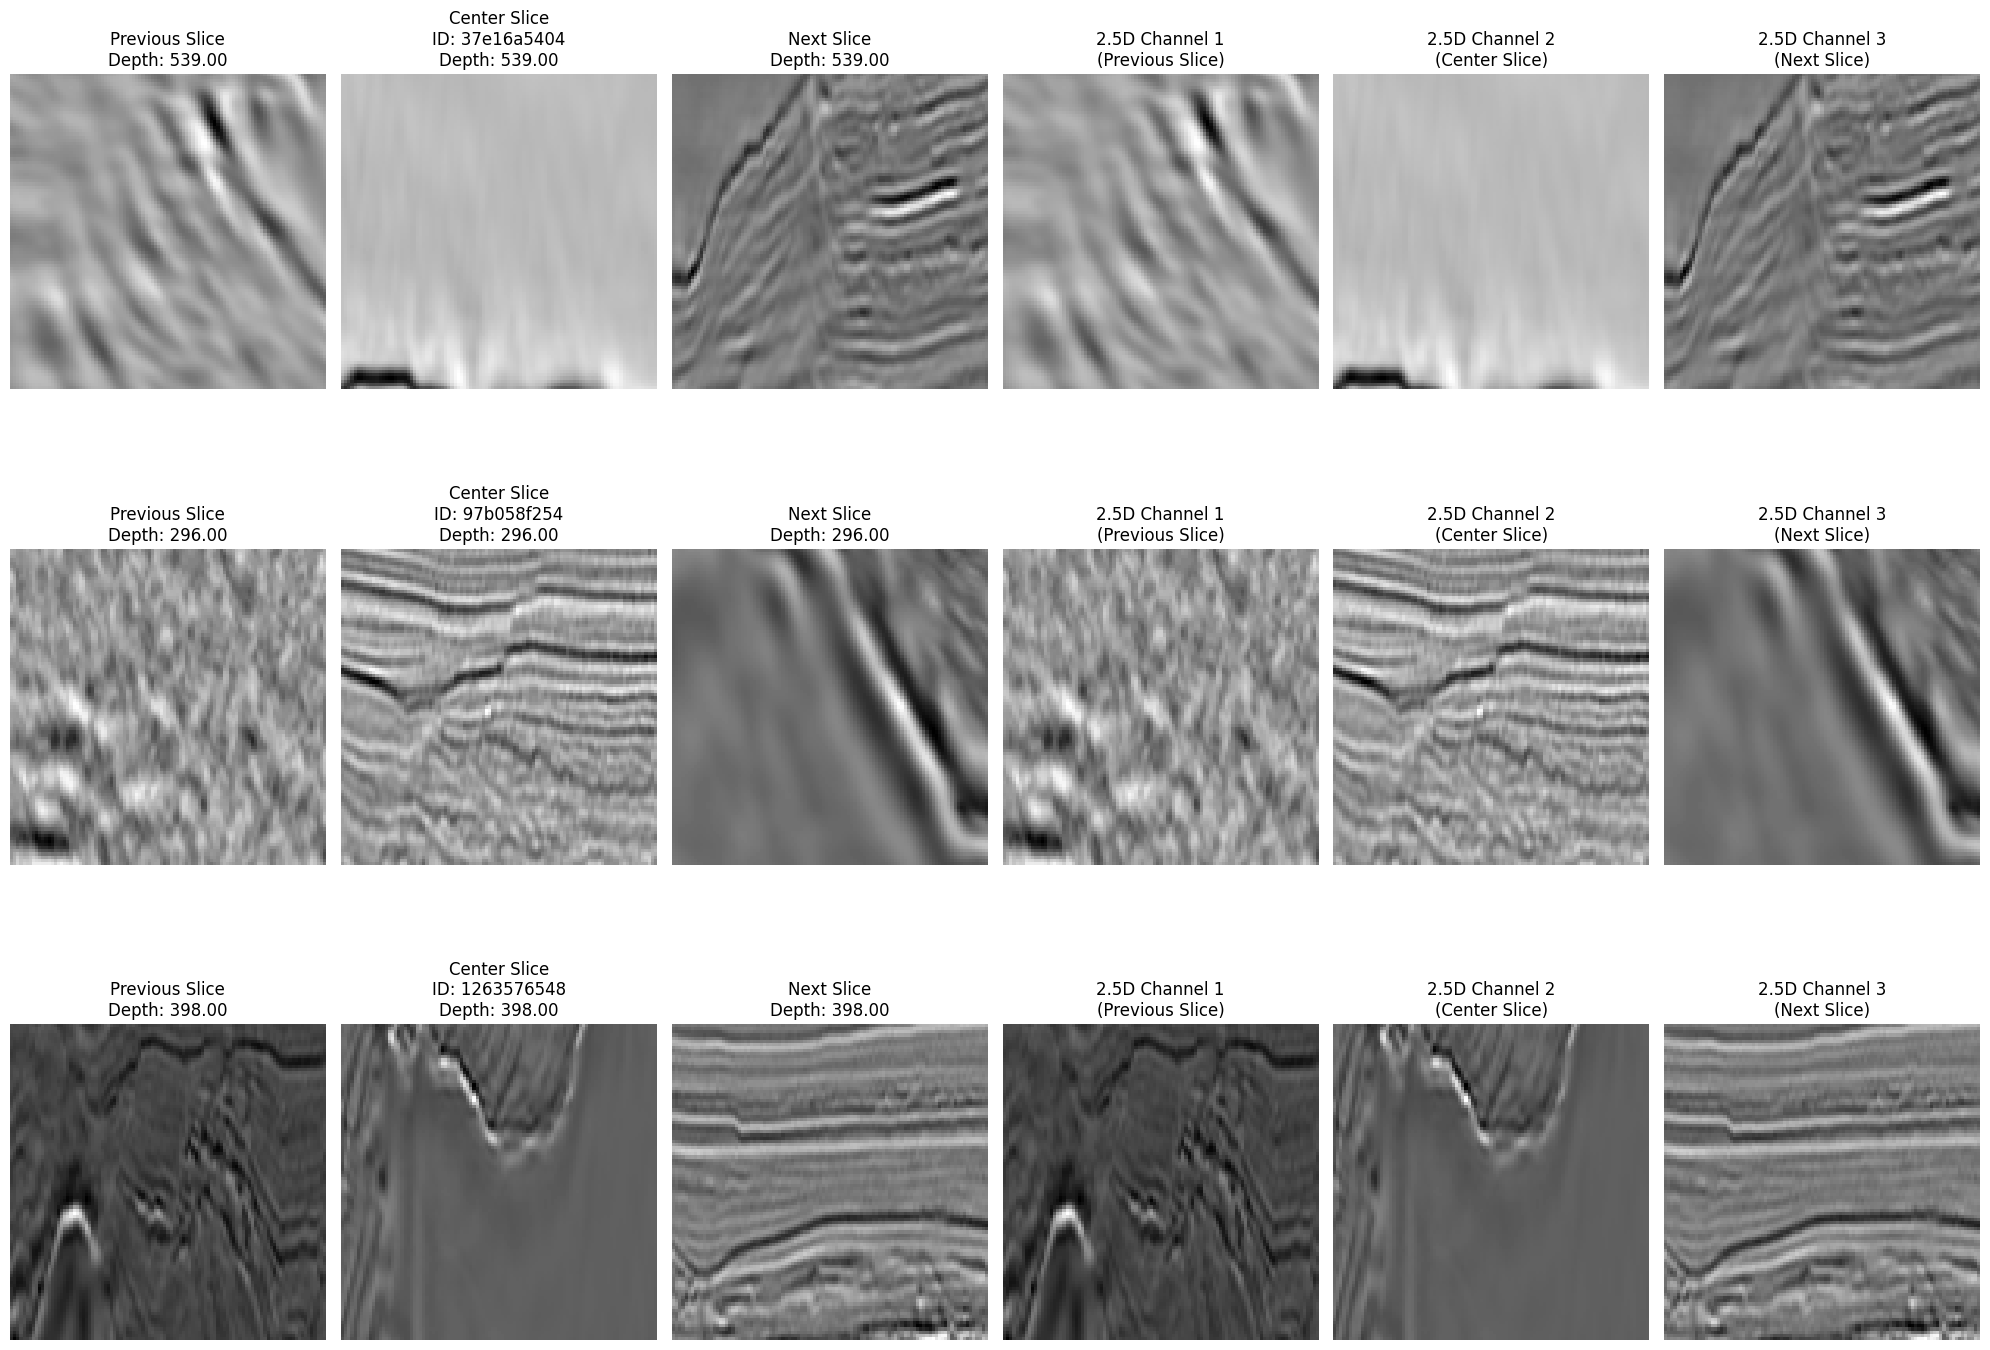

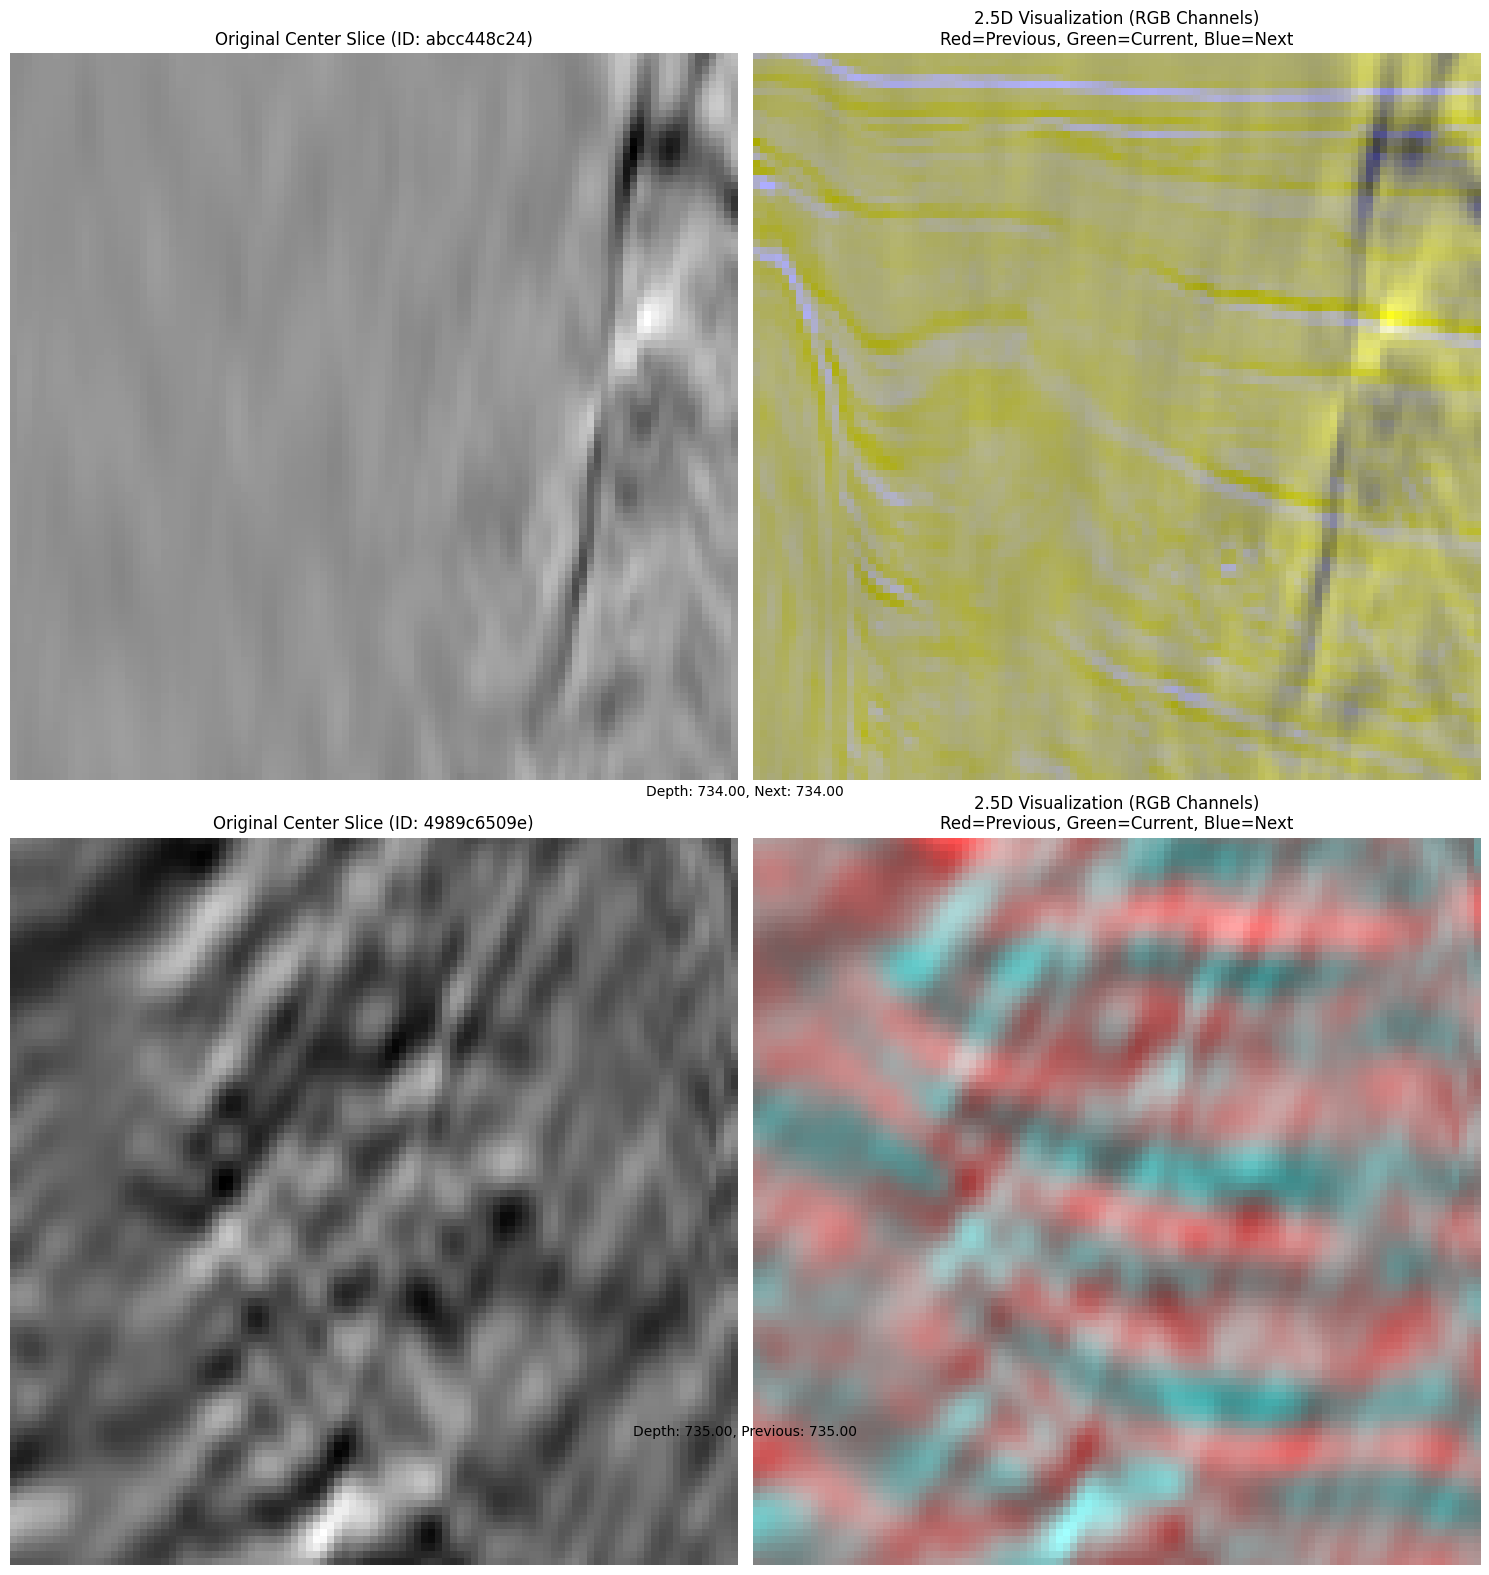

In [9]:
# visualize the 2.5D stacking

# Function to get individual slices from a 2.5D image
def get_individual_slices(idx):
    """
    Extract and return individual slices from a 2.5D image
    """
    image_id = dataset.image_ids[idx]
    
    # Get neighbor indices
    prev_idx, next_idx = dataset._get_neighbor_slices(idx)
    
    # Load center slice
    center_slice = dataset._load_image(image_id)
    if len(center_slice.shape) > 2:  # Has channels
        center_slice = np.mean(center_slice, axis=2, keepdims=False)
    
    # Load neighbor slices or duplicate center slice if neighbors don't exist
    prev_slice = None
    next_slice = None
    
    if prev_idx is not None:
        prev_image_id = dataset.image_ids[prev_idx]
        prev_slice = dataset._load_image(prev_image_id)
        if len(prev_slice.shape) > 2:
            prev_slice = np.mean(prev_slice, axis=2, keepdims=False)
    else:
        prev_slice = center_slice.copy()
        
    if next_idx is not None:
        next_image_id = dataset.image_ids[next_idx]
        next_slice = dataset._load_image(next_image_id)
        if len(next_slice.shape) > 2:
            next_slice = np.mean(next_slice, axis=2, keepdims=False)
    else:
        next_slice = center_slice.copy()
    
    # Load mask for center slice
    mask = dataset._load_mask(image_id)
    
    # Return info about the slices and their indices
    slice_info = {
        'prev_slice': prev_slice,
        'center_slice': center_slice,
        'next_slice': next_slice,
        'mask': mask,
        'prev_idx': prev_idx,
        'center_idx': idx,
        'next_idx': next_idx,
        'prev_id': dataset.image_ids[prev_idx] if prev_idx is not None else None,
        'center_id': image_id,
        'next_id': dataset.image_ids[next_idx] if next_idx is not None else None,
    }
    
    if dataset.depth_values is not None:
        slice_info['prev_depth'] = dataset.depth_values[prev_idx] if prev_idx is not None else None
        slice_info['center_depth'] = dataset.depth_values[idx]
        slice_info['next_depth'] = dataset.depth_values[next_idx] if next_idx is not None else None
    
    return slice_info

# Visualize 2.5D slices for random samples
num_samples = 3
plt.figure(figsize=(20, 5 * num_samples))

for i in range(num_samples):
    idx = random.randint(0, len(dataset)-1)
    slice_info = get_individual_slices(idx)
    
    # Get the 2.5D combined image (as returned by dataset)
    combined_image, mask = dataset[idx]
    combined_image = combined_image.numpy()
    
    # Create a 2x3 subplot
    plt.subplot(num_samples, 6, i*6 + 1)
    plt.imshow(slice_info['prev_slice'], cmap='gray')
    prev_label = f"Previous Slice"
    if slice_info['prev_depth'] is not None:
        prev_label += f"\nDepth: {slice_info['prev_depth']:.2f}"
    plt.title(prev_label)
    plt.axis('off')
    
    plt.subplot(num_samples, 6, i*6 + 2)
    plt.imshow(slice_info['center_slice'], cmap='gray')
    center_label = f"Center Slice\nID: {slice_info['center_id']}"
    if slice_info['center_depth'] is not None:
        center_label += f"\nDepth: {slice_info['center_depth']:.2f}"
    plt.title(center_label)
    plt.axis('off')
    
    plt.subplot(num_samples, 6, i*6 + 3)
    plt.imshow(slice_info['next_slice'], cmap='gray')
    next_label = f"Next Slice"
    if slice_info['next_depth'] is not None:
        next_label += f"\nDepth: {slice_info['next_depth']:.2f}"
    plt.title(next_label)
    plt.axis('off')
    
    # Visualize the 3 channels of the combined image (RGB representation)
    plt.subplot(num_samples, 6, i*6 + 4)
    plt.imshow(combined_image[0], cmap='gray')
    plt.title("2.5D Channel 1\n(Previous Slice)")
    plt.axis('off')
    
    plt.subplot(num_samples, 6, i*6 + 5)
    plt.imshow(combined_image[1], cmap='gray')
    plt.title("2.5D Channel 2\n(Center Slice)")
    plt.axis('off')
    
    plt.subplot(num_samples, 6, i*6 + 6)
    plt.imshow(combined_image[2], cmap='gray')
    plt.title("2.5D Channel 3\n(Next Slice)")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Create a colorful visualization of the 2.5D representation
num_samples = 2
plt.figure(figsize=(15, 8 * num_samples))

for i in range(num_samples):
    idx = random.randint(0, len(dataset)-1)
    slice_info = get_individual_slices(idx)
    
    # Get the 2.5D combined image
    combined_image, mask = dataset[idx]
    combined_image = combined_image.numpy()
    
    # Create a false color representation (RGB channels)
    rgb_image = np.zeros((combined_image.shape[1], combined_image.shape[2], 3))
    rgb_image[:,:,0] = combined_image[0]  # Previous slice -> Red
    rgb_image[:,:,1] = combined_image[1]  # Current slice -> Green
    rgb_image[:,:,2] = combined_image[2]  # Next slice -> Blue
    
    # Normalize for better visualization
    rgb_image = np.clip(rgb_image, 0, 1)
    
    # Create a 2-row visualization
    plt.subplot(num_samples, 2, i*2 + 1)
    plt.imshow(slice_info['center_slice'], cmap='gray')
    plt.title(f"Original Center Slice (ID: {slice_info['center_id']})")
    plt.axis('off')
    
    plt.subplot(num_samples, 2, i*2 + 2)
    plt.imshow(rgb_image)
    plt.title("2.5D Visualization (RGB Channels)\nRed=Previous, Green=Current, Blue=Next")
    plt.axis('off')
    
    # Add depth info if available
    if slice_info['center_depth'] is not None:
        depth_info = f"Depth: {slice_info['center_depth']:.2f}"
        if slice_info['prev_depth'] is not None:
            depth_info += f", Previous: {slice_info['prev_depth']:.2f}"
        if slice_info['next_depth'] is not None:
            depth_info += f", Next: {slice_info['next_depth']:.2f}"
        plt.figtext(0.5, 0.5 - i*0.4, depth_info, ha='center')

plt.tight_layout()
plt.show()

## Model Inference

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
from typing import Dict
import yaml
from utils.path_utils import prepare_data_paths

def load_config(config_path: str) -> Dict:
    """Load configuration from YAML file and resolve paths."""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    
    # Resolve and prepare all data paths
    config = prepare_data_paths(config)
    
    return config

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from inference.predictor import Predictor
from inference.refinement import RefinementNet
from models.segmentation_model import SaltSegmentationModel
from utils.visualization import plot_prediction_grid, create_overlay
import torch.nn.functional as F
from tqdm.notebook import tqdm

config_path = 'configs/default.yaml'
config = config = load_config(config_path)

# Load the main segmentation model
def load_segmentation_model(checkpoint_path, config):
    model = SaltSegmentationModel(
        model_name=config['model']['swin_variant'],
        in_channels=config['model']['in_channels'],
        seg_out_channels=config['model']['seg_out_channels'],
        cls_out_channels=config['model']['cls_out_channels'],
        pretrained=False  # We're loading from checkpoint
    )
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(checkpoint_path, map_location=device)
    state_dict = checkpoint['model_state_dict']
    
    # Handle distributed model checkpoint if needed
    if next(iter(state_dict.keys())).startswith('module.'):
        state_dict = {k[7:]: v for k, v in state_dict.items()}
        
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model, device

# Load refinement model if available
def load_refinement_model(checkpoint_path, device):
    refine_model = RefinementNet(
        in_channels=5,  # image (3) + mask (1) + uncertainty (1)
        base_channels=16,
        num_levels=3
    )
    refine_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    refine_model = refine_model.to(device)
    refine_model.eval()
    return refine_model

# Setup models
checkpoint_path = "checkpoints/logs/20250411_064607/model_best.pth"
model, device = load_segmentation_model(checkpoint_path, config)

# Create predictor for inference with uncertainty
predictor = Predictor(
    model=model,
    device=device,
    threshold=0.5,
    use_tta=True,  # Test-time augmentation
    use_mc_dropout=True,  # Monte Carlo dropout for uncertainty
    mc_samples=30
)

# Optionally load refinement model
try:
    refinement_path = "checkpoints/refinement_model.pth"
    refine_model = load_refinement_model(refinement_path, device)
    use_refinement = True
    print("Refinement model loaded successfully")
except:
    use_refinement = False
    print("No refinement model available")

Refinement model loaded successfully


In [13]:
# Function to visualize predictions for a single example
def visualize_prediction(image, mask, predictions, uncertainty=None, refined=None, figsize=(15, 5)):
    """
    Visualize prediction results for a single sample.
    
    Args:
        image: Input image tensor or array
        mask: Ground truth mask tensor or array
        predictions: Model prediction tensor or array
        uncertainty: Uncertainty map (optional)
        refined: Refined prediction (optional)
        figsize: Figure size
    """
    # Convert tensors to numpy arrays if needed
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    if uncertainty is not None and isinstance(uncertainty, torch.Tensor):
        uncertainty = uncertainty.cpu().numpy()
    if refined is not None and isinstance(refined, torch.Tensor):
        refined = refined.cpu().numpy()
    
    # Normalize and prepare for visualization
    if image.shape[0] in [1, 3]:  # Handle CHW format
        image = np.transpose(image, (1, 2, 0))
    if len(image.shape) > 2 and image.shape[-1] == 1:
        image = image.squeeze(-1)
    
    if len(mask.shape) > 2 and mask.shape[0] == 1:
        mask = mask.squeeze(0)
    if len(mask.shape) > 2 and mask.shape[-1] == 1:
        mask = mask.squeeze(-1)
    
    if len(predictions.shape) > 2 and predictions.shape[0] == 1:
        predictions = predictions.squeeze(0)
    if len(predictions.shape) > 2 and predictions.shape[-1] == 1:
        predictions = predictions.squeeze(-1)
    
    if uncertainty is not None:
        if len(uncertainty.shape) > 2 and uncertainty.shape[0] == 1:
            uncertainty = uncertainty.squeeze(0)
        if len(uncertainty.shape) > 2 and uncertainty.shape[-1] == 1:
            uncertainty = uncertainty.squeeze(-1)
    
    # Determine number of plots
    n_plots = 3
    if uncertainty is not None:
        n_plots += 1
    if refined is not None:
        n_plots += 1
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot original image
    plt.subplot(1, n_plots, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot ground truth mask
    plt.subplot(1, n_plots, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Plot prediction
    plt.subplot(1, n_plots, 3)
    plt.imshow(predictions, cmap='gray')
    plt.title('Prediction')
    plt.axis('off')
    
    plot_idx = 4
    
    # Plot uncertainty if available
    if uncertainty is not None:
        plt.subplot(1, n_plots, plot_idx)
        plt.imshow(uncertainty, cmap='magma')
        plt.title('Uncertainty')
        plt.axis('off')
        plot_idx += 1
    
    # Plot refined prediction if available
    if refined is not None:
        plt.subplot(1, n_plots, plot_idx)
        plt.imshow(refined, cmap='gray')
        plt.title('Refined Prediction')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to create overlay of prediction on original image
def visualize_overlay(image, mask, prediction, alpha=0.5, figsize=(15, 5)):
    """
    Visualize overlay of prediction on original image.
    """
    # Preprocess image and masks if needed
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.cpu().numpy()
    
    # Normalize and prepare for visualization
    if image.shape[0] in [1, 3]:  # Handle CHW format
        image = np.transpose(image, (1, 2, 0))
    if len(image.shape) > 2 and image.shape[-1] == 1:
        image = image.squeeze(-1)
    
    # Ensure masks are proper dimensions
    if len(mask.shape) > 2:
        mask = mask.squeeze()
    if len(prediction.shape) > 2:
        prediction = prediction.squeeze()
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot ground truth overlay
    plt.subplot(1, 3, 2)
    gt_overlay = create_overlay(image, mask, alpha=alpha, mask_color=[0, 1, 0])  # Green for ground truth
    plt.imshow(gt_overlay)
    plt.title('Ground Truth Overlay')
    plt.axis('off')
    
    # Plot prediction overlay
    plt.subplot(1, 3, 3)
    pred_overlay = create_overlay(image, prediction, alpha=alpha, mask_color=[1, 0, 0])  # Red for prediction
    plt.imshow(pred_overlay)
    plt.title('Prediction Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [14]:
# Install Grad-CAM if not already installed
from pytorch_grad_cam import GradCAM

class SaltModelWrapper(torch.nn.Module):
    """Wrapper class for segmentation model to work with Grad-CAM."""
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        seg_logits, _ = self.model(x)
        return seg_logits

def visualize_gradcam(model, image, mask=None, target_layer_name='encoder.backbone.layers.3', figsize=(15, 5)):
    """
    Visualize Grad-CAM for model explainability.
    
    Args:
        model: Segmentation model
        image: Input image tensor (should be on CPU)
        mask: Ground truth mask (optional)
        target_layer_name: Name of the target layer for Grad-CAM
        figsize: Figure size
    """
    # Prepare model and image
    device = next(model.parameters()).device
    wrapped_model = SaltModelWrapper(model)
    
    # Find target layer
    target_layer = None
    for name, module in wrapped_model.named_modules():
        if name == target_layer_name:
            target_layer = module
            break
    
    if target_layer is None:
        print(f"Couldn't find layer: {target_layer_name}")
        print("Available layers:")
        for name, _ in wrapped_model.named_modules():
            print(f"- {name}")
        return
    
    # Initialize Grad-CAM
    cam = GradCAM(model=wrapped_model, target_layers=[target_layer], use_cuda=device.type=='cuda')
    
    # Prepare input
    if isinstance(image, np.ndarray):
        if len(image.shape) == 3 and image.shape[0] in [1, 3]:
            # Already in correct format (C,H,W)
            input_tensor = torch.from_numpy(image).float().unsqueeze(0)
        else:
            # Convert from (H,W,C) to (C,H,W)
            input_tensor = torch.from_numpy(np.transpose(image, (2, 0, 1))).float().unsqueeze(0)
    else:
        input_tensor = image.clone().detach().cpu().unsqueeze(0) if image.dim() == 3 else image.clone().detach().cpu()
    
    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor.to(device))
    grayscale_cam = grayscale_cam[0, :]
    
    # Prepare image for visualization
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if image.shape[0] in [1, 3]:  # CHW format
        image = np.transpose(image, (1, 2, 0))
    if len(image.shape) > 2 and image.shape[-1] == 1:
        image = image.squeeze(-1)
    
    # Normalize image to 0-1 for visualization
    image_normalized = image.copy()
    if image_normalized.max() > 1:
        image_normalized = image_normalized / 255.0
    
    # If grayscale, convert to RGB
    if len(image_normalized.shape) == 2:
        image_normalized = np.stack([image_normalized] * 3, axis=-1)
    
    # Create heatmap visualization
    cam_image = show_cam_on_image(image_normalized, grayscale_cam, use_rgb=True)
    
    # Create visualization
    plt.figure(figsize=figsize)
    
    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title("Original Image")
    plt.axis("off")
    
    # Plot Grad-CAM heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(cam_image)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    
    # Plot ground truth or prediction
    if mask is not None:
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        if len(mask.shape) > 2 and mask.shape[0] == 1:
            mask = mask.squeeze(0)
        if len(mask.shape) > 2 and mask.shape[-1] == 1:
            mask = mask.squeeze(-1)
            
        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

Generating predictions:   0%|          | 0/4 [00:00<?, ?it/s]

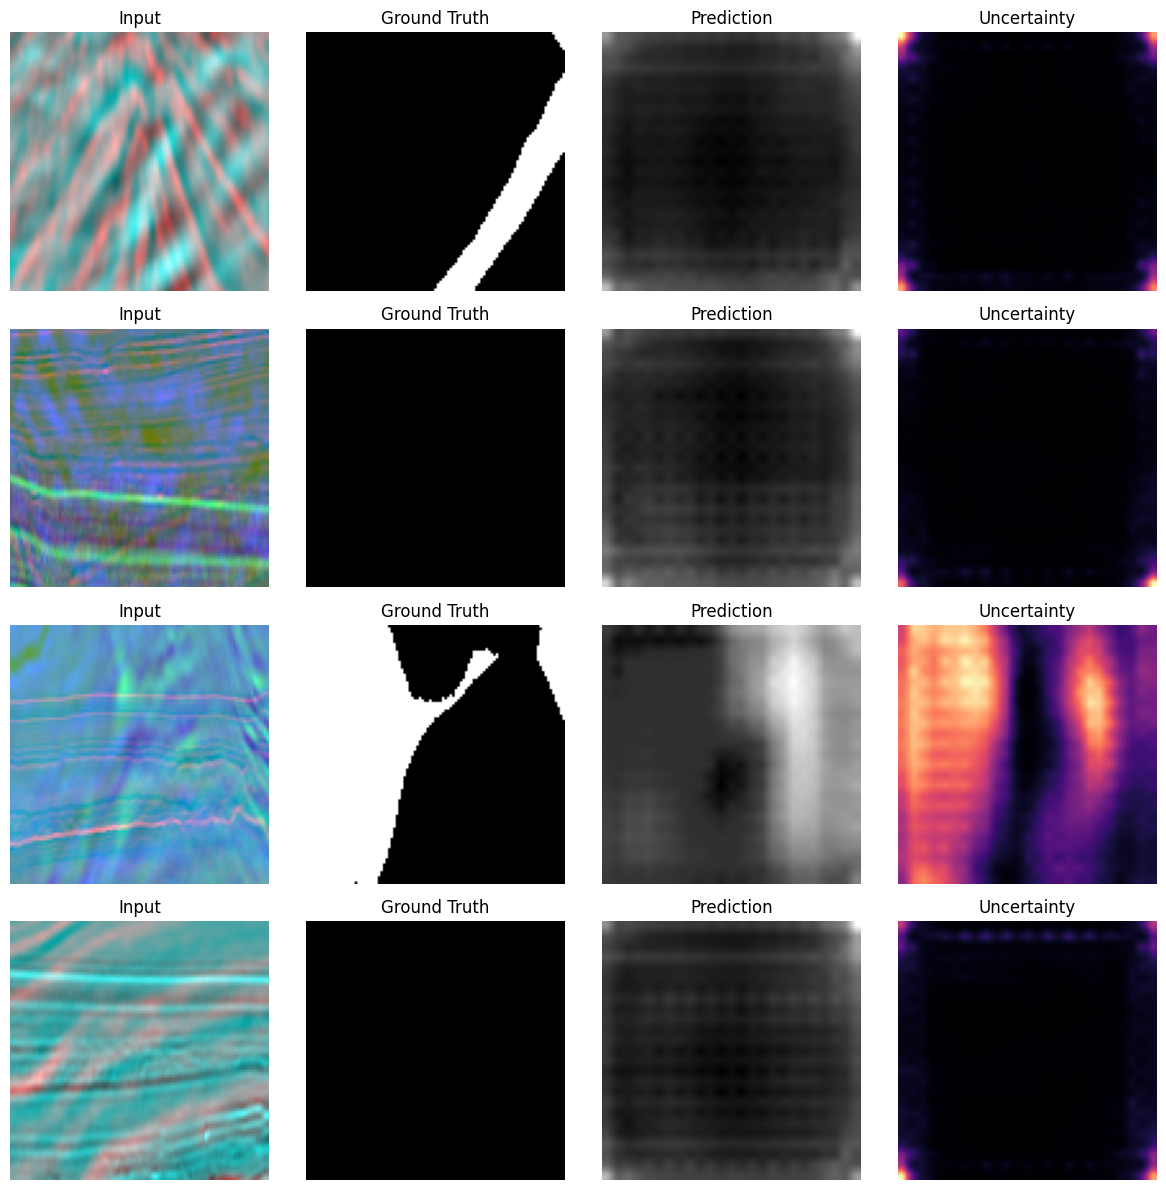

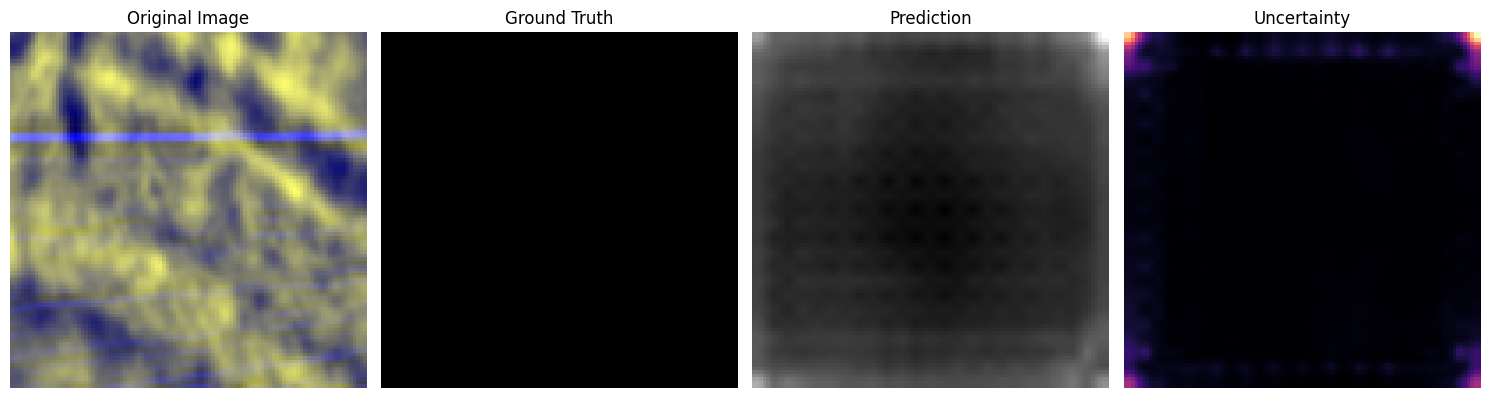

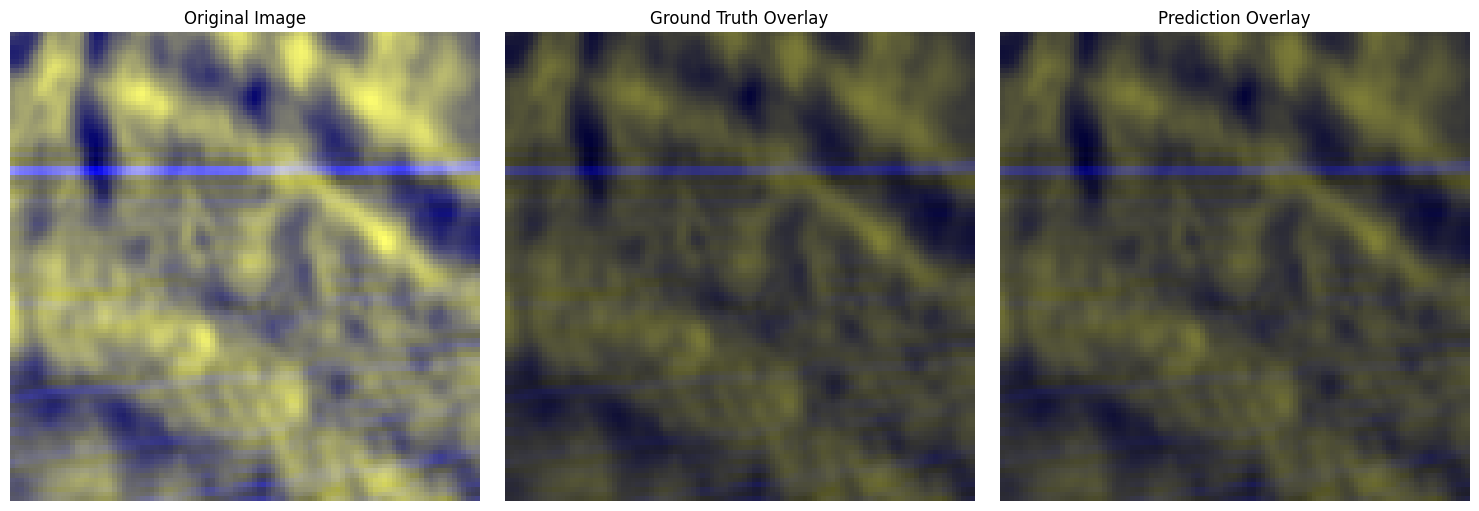

Couldn't find layer: encoder.backbone.layers.3
Available layers:
- 
- model
- model.encoder
- model.encoder.backbone
- model.encoder.backbone.patch_embed
- model.encoder.backbone.patch_embed.proj
- model.encoder.backbone.patch_embed.norm
- model.encoder.backbone.layers_0
- model.encoder.backbone.layers_0.downsample
- model.encoder.backbone.layers_0.blocks
- model.encoder.backbone.layers_0.blocks.0
- model.encoder.backbone.layers_0.blocks.0.norm1
- model.encoder.backbone.layers_0.blocks.0.attn
- model.encoder.backbone.layers_0.blocks.0.attn.qkv
- model.encoder.backbone.layers_0.blocks.0.attn.attn_drop
- model.encoder.backbone.layers_0.blocks.0.attn.proj
- model.encoder.backbone.layers_0.blocks.0.attn.proj_drop
- model.encoder.backbone.layers_0.blocks.0.attn.softmax
- model.encoder.backbone.layers_0.blocks.0.drop_path1
- model.encoder.backbone.layers_0.blocks.0.norm2
- model.encoder.backbone.layers_0.blocks.0.mlp
- model.encoder.backbone.layers_0.blocks.0.mlp.fc1
- model.encoder.backbone

In [15]:
# Function to run and visualize predictions on multiple samples
def visualize_prediction_batch(dataset, indices=None, num_samples=8, use_refinement=False):
    """
    Visualize predictions on multiple samples.
    
    Args:
        dataset: Dataset containing images and masks
        indices: Optional list of specific indices to use
        num_samples: Number of samples to visualize (if indices not provided)
        use_refinement: Whether to use refinement model
    """
    # Generate random indices if not provided
    if indices is None:
        indices = np.random.choice(len(dataset), size=num_samples, replace=False)
    else:
        num_samples = len(indices)
    
    # Prepare lists for visualization
    images_list = []
    masks_list = []
    preds_list = []
    uncertainties_list = []
    refined_list = [] if use_refinement else None
    
    # Process each sample
    for idx in tqdm(indices, desc="Generating predictions"):
        # Get image and mask
        image, mask = get_processed_sample(idx)
        
        # Prepare for model
        if isinstance(image, np.ndarray):
            # Check if already in CHW format (channels first)
            if len(image.shape) == 3 and image.shape[0] in [1, 3]:
                # Already in CHW format
                image_tensor = torch.from_numpy(image)
            elif len(image.shape) == 3 and image.shape[-1] in [1, 3]:
                # Convert from HWC to CHW
                image_tensor = torch.from_numpy(np.transpose(image, (2, 0, 1)))
            else:
                image_tensor = torch.from_numpy(image)
        else:
            image_tensor = image
            
        # Add batch dimension
        image_tensor = image_tensor.unsqueeze(0).float().to(device)
        
        # Get predictions with uncertainty
        with torch.no_grad():
            predictions = predictor.predict_batch(image_tensor)
            
            # Apply refinement if available
            if use_refinement:
                # Combine image, prediction and uncertainty for refinement
                refined_input = torch.cat([
                    image_tensor,
                    predictions['seg_pred'],
                    predictions['seg_var']
                ], dim=1)
                
                refined_pred = refine_model(refined_input)
                refined_pred = torch.sigmoid(refined_pred)
        
        # Store results
        images_list.append(image)
        masks_list.append(mask)
        preds_list.append(predictions['seg_pred'][0].cpu().numpy())
        uncertainties_list.append(predictions['seg_var'][0].cpu().numpy())
        
        if use_refinement:
            refined_list.append(refined_pred[0].cpu().numpy())
    
    # Visualize grid of results
    plot_prediction_grid(
        images=images_list,
        masks=masks_list,
        predictions=preds_list,
        uncertainties=uncertainties_list,
        num_examples=num_samples
    )
    
    # Return data for further analysis
    return {
        'indices': indices,
        'images': images_list,
        'masks': masks_list,
        'predictions': preds_list,
        'uncertainties': uncertainties_list,
        'refined': refined_list
    }

# Add a function for detailed analysis on a single sample
def analyze_sample(dataset, idx, use_gradcam=True):
    """
    Perform detailed analysis on a single sample.
    """
    # Get image and mask
    image, mask = get_processed_sample(idx)
    
    # Store the original image format for visualization
    original_image = image.copy() if isinstance(image, np.ndarray) else image.clone()
    
    # Prepare for model
    if isinstance(image, np.ndarray):
        if len(image.shape) == 3 and image.shape[-1] in [1, 3]:
            # Convert from HWC to CHW
            image_tensor = torch.from_numpy(np.transpose(image, (2, 0, 1)))
        else:
            image_tensor = torch.from_numpy(image)
    else:
        image_tensor = image
        
    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0).float().to(device)
    
    # Get predictions with uncertainty
    with torch.no_grad():
        predictions = predictor.predict_batch(image_tensor)
        
        # Apply refinement if available
        refined_pred = None
        if use_refinement:
            # Existing refinement code...
            pass
    
    # 1. Visualize prediction with uncertainty - use original image format
    visualize_prediction(
        image=original_image,  # Use original image format instead of tensor
        mask=mask,
        predictions=predictions['seg_pred'][0].cpu().numpy(),
        uncertainty=predictions['seg_var'][0].cpu().numpy(),
        refined=refined_pred[0].cpu().numpy() if refined_pred is not None else None
    )
    
    # 2. Visualize overlay - use original image format
    visualize_overlay(
        image=original_image,  # Use original image format instead of tensor
        mask=mask,
        prediction=predictions['seg_pred'][0].cpu().numpy()
    )
    
    # 3. Visualize with Grad-CAM if requested
    if use_gradcam:
        visualize_gradcam(
            model=model,
            image=image_tensor,  # Keep tensor format for Grad-CAM which needs it
            mask=mask
        )
    
    return {
        'image': original_image,
        'mask': mask,
        'predictions': predictions,
        'refined': refined_pred
    }

# Example usage: visualize predictions on multiple samples
results = visualize_prediction_batch(dataset, num_samples=4, use_refinement=use_refinement)

# Example usage: detailed analysis on a single sample
sample_idx = 42  # Choose any index
analysis = analyze_sample(dataset, sample_idx)

In [20]:
import scipy

def analyze_uncertainty_patterns(dataset, model, num_samples=100):
    """Analyze where uncertainty is highest"""
    depth_values = []
    uncertainty_values = []
    boundary_proximity = []
    
    for i in range(num_samples):
        idx = random.randint(0, len(dataset)-1)
        image, mask = get_processed_sample(idx)
        depth = dataset.depth_values[idx] if hasattr(dataset, 'depth_values') else None
        
        # Get prediction and uncertainty
        with torch.no_grad():
            image_chw = torch.from_numpy(np.transpose(image, (2, 0, 1)))
            image_chw = image_chw.unsqueeze(0).float().to(device)
            pred = predictor.predict_batch(image_chw)
            uncertainty = pred['seg_var'].cpu().numpy().mean()
        
        # Calculate distance to boundary
        if mask.sum() > 0 and mask.sum() < mask.size:
            # Convert mask to a boolean array
            mask_bool = mask.astype(bool)
            boundary = scipy.ndimage.binary_dilation(mask_bool) ^ mask_bool
            dist_to_boundary = np.mean(boundary)
        else:
            dist_to_boundary = 0
            
        depth_values.append(depth)
        uncertainty_values.append(uncertainty)
        boundary_proximity.append(dist_to_boundary)
    
    # Plot relationships
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(depth_values, uncertainty_values)
    plt.xlabel("Depth")
    plt.ylabel("Uncertainty")
    plt.title("Uncertainty vs Depth")
    
    plt.subplot(1, 2, 2)
    plt.scatter(boundary_proximity, uncertainty_values)
    plt.xlabel("Boundary Proximity")
    plt.ylabel("Uncertainty")
    plt.title("Uncertainty vs Boundary Proximity")
    
    plt.tight_layout()
    plt.show()

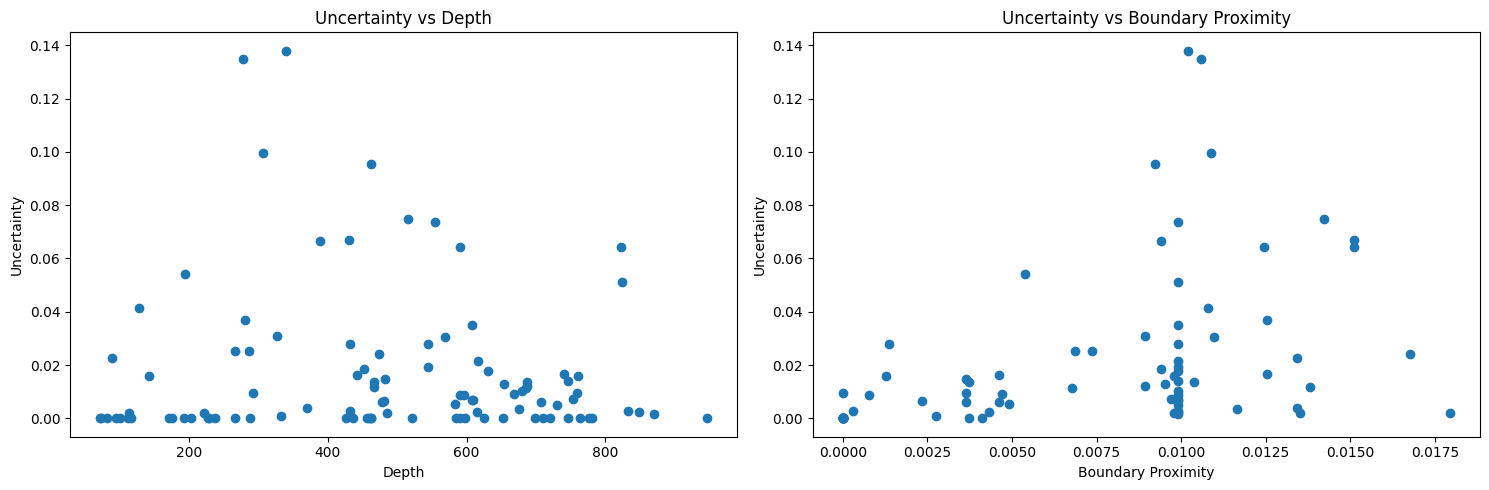

In [21]:
import random
analyze_uncertainty_patterns(dataset, model, num_samples=100)